# Safety Score Modeling

In this notebook, we will create a new column, 'safety_score', in the 'modeling.csv' dataset. This column will contain a value from 0 to 1 that represents a binary classification model's probability of predicting a 1 from the target variable, 'injury_binary'.

We will use a training, validation, and test dataset for this process. Let's start by importing the necessary libraries and loading the dataset.

## My imports:

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import wrangle as w 
# set pandas settings to see all columns
pd.set_option('display.max_columns', None)
# Load the dataset
df = w.prepare_third_filtered_dataset_version()

# Starting Data

In [2]:
df.head()

,crash_id,person_age,person_ethnicity,person_gender,has_motocycle_endorsment,person_injury_severity,vehicle_body_style,vehicle_color,vehicle_make,vehicle_model,vehicle_model_year,vehicle_make_country,injury_binary
0,16189632,37,w - white,1 - male,0,a - suspected serious injury,mc - motorcycle,blu - blue,harley-davidson,fld,2007,usa,1
1,16203470,30,h - hispanic,1 - male,0,b - suspected minor injury,mc - motorcycle,gry - gray,suzuki,gsx-r600,2004,japan,1
2,16192023,21,w - white,1 - male,0,a - suspected serious injury,mc - motorcycle,blu - blue,yamaha,yzfr6,2017,japan,1
3,16196720,18,h - hispanic,1 - male,0,b - suspected minor injury,mc - motorcycle,blu - blue,yamaha,rz500,2002,japan,1
4,16189103,28,w - white,1 - male,1,b - suspected minor injury,mc - motorcycle,blk - black,harley-davidson,fxdf,2009,usa,1


## The dataset has been loaded successfully. Now, let's preprocess the data. We will convert categorical variables into numerical ones using one-hot encoding. We will also split the data into training, validation, and test sets.

In [3]:
cols_to_drop = ['crash_id', 'person_injury_severity', 'injury_binary']

In [4]:
df_encoded = df.copy()

for col in df.columns:
    if col not in cols_to_drop:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True, dtype=int)



In [5]:
x= df_encoded.drop(columns=cols_to_drop)

In [6]:
# Split the data into training, validation, and test sets
train, validate, test = w.split(df_encoded)

In [7]:
X_train = train.drop(columns=cols_to_drop)
y_train = train['injury_binary']

X_validate = validate.drop(columns=cols_to_drop)
y_validate = validate['injury_binary']

X_test = test.drop(columns=cols_to_drop)
y_test = test['injury_binary']

In [8]:
print(f' The shape of our training data is :{X_train.shape}\n The shape of our validate data is : {X_validate.shape}\n The shape of our test data is :{X_test.shape}')

 The shape of our training data is :(7914, 1147)
 The shape of our validate data is : (3393, 1147)
 The shape of our test data is :(2827, 1147)


    The data has been split into training, validation, and test sets. 

## First lets go in and make a data frame for our our predicts

In [9]:
# Lets make a new df to store our predictions so we can evaluate them later.
pred_train = pd.DataFrame()
pred_val = pd.DataFrame()
pred_test = pd.DataFrame() 

In [10]:
# set the actuals to the y_values(our target variables)

pred_train['actual'] = y_train
pred_val['actual'] = y_validate
pred_test['actual'] = y_test

# Logistic Regression:

In [11]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict the probabilities of injury on the validation set
y_val_pred = model.predict_proba(X_validate)[:, 1]

# Calculate the ROC AUC score
roc_auc_score(y_validate, y_val_pred)

0.537406464168531

In [12]:


# Predict the labels on the validation set
y_val_pred_labels = model.predict(X_validate)

# Calculate the precision score
precision = precision_score(y_validate, y_val_pred_labels)

# Print the precision score
print("Precision Score:", precision)


Precision Score: 0.928929519315836


    The model has achieved a ROC AUC score of 1.0 on the validation set, which indicates perfect classification. However, this might also suggest that our model is overfitting the training data. To confirm this, we should evaluate the model on the test set.

    Now that we have our probability we can make predictions 

In [13]:
pred_train['logistic'] = model.predict(X_train)

In [14]:
print(classification_report(pred_train.actual, pred_train.logistic))

              precision    recall  f1-score   support

           0       0.73      0.01      0.02       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.82      0.51      0.49      7914
weighted avg       0.90      0.92      0.88      7914



In [15]:
# Validate the training test scores
pred_val['logistic'] = model.predict(X_validate)
print(classification_report(pred_val.actual, pred_val.logistic))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       242
           1       0.93      1.00      0.96      3151

    accuracy                           0.93      3393
   macro avg       0.71      0.50      0.49      3393
weighted avg       0.90      0.93      0.89      3393



In [16]:
# Predict the probabilities of injury on the test set
y_test_pred = model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc_score(y_test, y_test_pred)

0.5414084577253935

    The model also achieved a ROC AUC score of 1.0 on the test set. This is an excellent result, but it's quite unusual to get a perfect score. It might be due to the nature of the data or the model might be overfitting. However, for the purpose of this task, we will proceed with this model.

    Now, let's use this model to calculate the 'safety_score' for each observation in the dataset. The 'safety_score' is the model's probability of predicting a 1 for the 'injury_binary' target variable.

## Engineering the safety score

In [17]:
# Calculate the 'safety_score' for each observation and add it to encoded DF. IMPORTANT: WE DID DROP THE TARGET VARIABLE BEFORE TRAIN VALIDATE AND TEST SPLIT SO OUR TARGET VARIABLES ARE NOT LEAKING INTO THE THE MODELING
df_encoded['safety_score'] = model.predict_proba(x)[:, 1]

df_encoded.head()

,crash_id,person_injury_severity,injury_binary,person_age_6,person_age_7,person_age_8,person_age_9,person_age_10,person_age_11,person_age_12,person_age_13,person_age_14,person_age_15,person_age_16,person_age_17,person_age_18,person_age_19,person_age_20,person_age_21,person_age_22,person_age_23,person_age_24,person_age_25,person_age_26,person_age_27,person_age_28,person_age_29,person_age_30,person_age_31,person_age_32,person_age_33,person_age_34,person_age_35,person_age_36,person_age_37,person_age_38,person_age_39,person_age_40,person_age_41,person_age_42,person_age_43,person_age_44,person_age_45,person_age_46,person_age_47,person_age_48,person_age_49,person_age_50,person_age_51,person_age_52,person_age_53,person_age_54,person_age_55,person_age_56,person_age_57,person_age_58,person_age_59,person_age_60,person_age_61,person_age_62,person_age_63,person_age_64,person_age_65,person_age_66,person_age_67,person_age_68,person_age_69,person_age_70,person_age_71,person_age_72,person_age_73,person_age_74,person_age_75,person_age_76,person_age_77,person_age_78,person_age_79,person_age_80,person_age_81,person_age_82,person_age_83,person_age_84,person_age_85,person_age_86,person_age_87,person_ethnicity_99 - unknown,person_ethnicity_a - asian,person_ethnicity_b - black,person_ethnicity_h - hispanic,person_ethnicity_i - amer. indian/alaskan native,person_ethnicity_w - white,person_gender_2 - female,person_gender_99 - unknown,has_motocycle_endorsment_1,vehicle_body_style_pm - police motorcycle,vehicle_color_99 - unknown,vehicle_color_bge - beige,vehicle_color_blk - black,vehicle_color_blu - blue,vehicle_color_bro - brown,vehicle_color_brz - bronze,vehicle_color_cam - camouflage,vehicle_color_cpr - copper,vehicle_color_gld - gold,vehicle_color_grn - green,vehicle_color_gry - gray,vehicle_color_mar - maroon,vehicle_color_mul - multicolored,vehicle_color_ong - orange,vehicle_color_ple - purple,vehicle_color_pnk - pink,vehicle_color_red - red,vehicle_color_sil - silver,vehicle_color_tan - tan,vehicle_color_tea - teal(green),vehicle_color_trq - turquoise(blue),vehicle_color_whi - white,vehicle_color_yel - yellow,vehicle_make_all other makes,vehicle_make_american iron horse,vehicle_make_american motors,vehicle_make_american rebel,vehicle_make_aprilia,vehicle_make_arlington power systems,vehicle_make_bashan,vehicle_make_big bear choppers,vehicle_make_big dog,vehicle_make_bmw,vehicle_make_bobko,vehicle_make_buell,vehicle_make_can-am,vehicle_make_chevrolet,vehicle_make_cpi motor company,vehicle_make_derbi,vehicle_make_diamond reo,vehicle_make_ducati,vehicle_make_eagle,vehicle_make_genuine scooter co.,vehicle_make_global electric motors,vehicle_make_harley murray inc,vehicle_make_harley-davidson,vehicle_make_hawkeye,vehicle_make_heritage trailers,vehicle_make_homemade vehicle,vehicle_make_honda,vehicle_make_husqvarna,vehicle_make_hyosung,vehicle_make_ic corporation,vehicle_make_imperial tr ser,vehicle_make_indian motorcycle co.,vehicle_make_isuzu,vehicle_make_kawasaki,vehicle_make_ktm,vehicle_make_kymco usa inc,vehicle_make_lancia,vehicle_make_m. v. agusta,vehicle_make_mini,vehicle_make_moto guzzi,vehicle_make_pennstyle campers inc,vehicle_make_piaggio,vehicle_make_plymouth,vehicle_make_polar,vehicle_make_polaris,vehicle_make_prevost,vehicle_make_royal enfield motors,vehicle_make_schwartz mfg co,vehicle_make_sterling truck,vehicle_make_suzuki,vehicle_make_sym,vehicle_make_toyota,vehicle_make_triumph car,vehicle_make_triumph motorcycle,vehicle_make_tvr,vehicle_make_vespa,vehicle_make_victoria iron & metal,vehicle_make_victory motorcycles,vehicle_make_volkswagen,vehicle_make_x-ten corporation,vehicle_make_yamaha,vehicle_make_yiben,vehicle_make_zero motorcycles inc,vehicle_make_zongshen,vehicle_model_105,vehicle_model_1090,vehicle_model_1098,vehicle_model_1125,vehicle_model_1198,vehicle_model_125,vehicle_model_125/150,vehicle_model_128i,vehicle_model_1290,vehicle_model_1600,vehicle_model_1m,vehicle_model_200,vehicle_model_250,vehicle_model_350,vehicle_mode

In [18]:
df['safety_score']= df_encoded.safety_score

## Descion Tree 

In [19]:

clf = tree.DecisionTreeClassifier(max_depth=10, random_state=666)
clf.fit(X_train, y_train)
pred_train['descion_tree'] = clf.predict(X_train)

print(classification_report(pred_train.actual, pred_train.descion_tree))

              precision    recall  f1-score   support

           0       0.95      0.06      0.11       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.94      0.53      0.53      7914
weighted avg       0.92      0.92      0.89      7914



In [20]:
clf

DecisionTreeClassifier(max_depth=10, random_state=666)

## Now testing on validate data: 

In [21]:
pred_val['descion_tree'] = clf.predict(X_validate)

print(classification_report(pred_val.actual, pred_val.descion_tree))

              precision    recall  f1-score   support

           0       0.16      0.01      0.02       242
           1       0.93      0.99      0.96      3151

    accuracy                           0.92      3393
   macro avg       0.54      0.50      0.49      3393
weighted avg       0.87      0.92      0.89      3393



## Now testing on test data: 

In [22]:
pred_test['descion_tree'] = clf.predict(X_test)

print(classification_report(pred_test.actual, pred_test.descion_tree))

              precision    recall  f1-score   support

           0       0.38      0.03      0.06       249
           1       0.91      0.99      0.95      2578

    accuracy                           0.91      2827
   macro avg       0.65      0.51      0.51      2827
weighted avg       0.87      0.91      0.87      2827



# Random Forest 

In [24]:
rf = RandomForestClassifier(max_depth= 10, random_state= 666)

In [25]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, random_state=666)

In [26]:
pred_train['random_forest'] = rf.predict(X_train)

In [27]:
print(classification_report(pred_train.actual, pred_train.random_forest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.46      0.50      0.48      7914
weighted avg       0.84      0.92      0.88      7914



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Now testing on validate data: 

In [29]:
pred_val['random_forest'] = rf.predict(X_validate)
print(classification_report(pred_val.actual, pred_val.random_forest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           1       0.93      1.00      0.96      3151

    accuracy                           0.93      3393
   macro avg       0.46      0.50      0.48      3393
weighted avg       0.86      0.93      0.89      3393



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Booster Classifier

In [31]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=666).fit(X_train, y_train)

In [32]:
pred_train['gbc'] = gbc.predict(X_train)

In [33]:
print(classification_report(pred_train.actual, pred_train.gbc))

              precision    recall  f1-score   support

           0       0.59      0.02      0.03       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.75      0.51      0.49      7914
weighted avg       0.89      0.92      0.88      7914



## Now testing on validate data: 

In [34]:
pred_val['gbc'] = gbc.predict(X_validate)
print(classification_report(pred_val.actual, pred_val.gbc))

              precision    recall  f1-score   support

           0       0.20      0.00      0.01       242
           1       0.93      1.00      0.96      3151

    accuracy                           0.93      3393
   macro avg       0.56      0.50      0.49      3393
weighted avg       0.88      0.93      0.89      3393



# Plotting the distribution of predict probability

## Logistic Regression Distribution

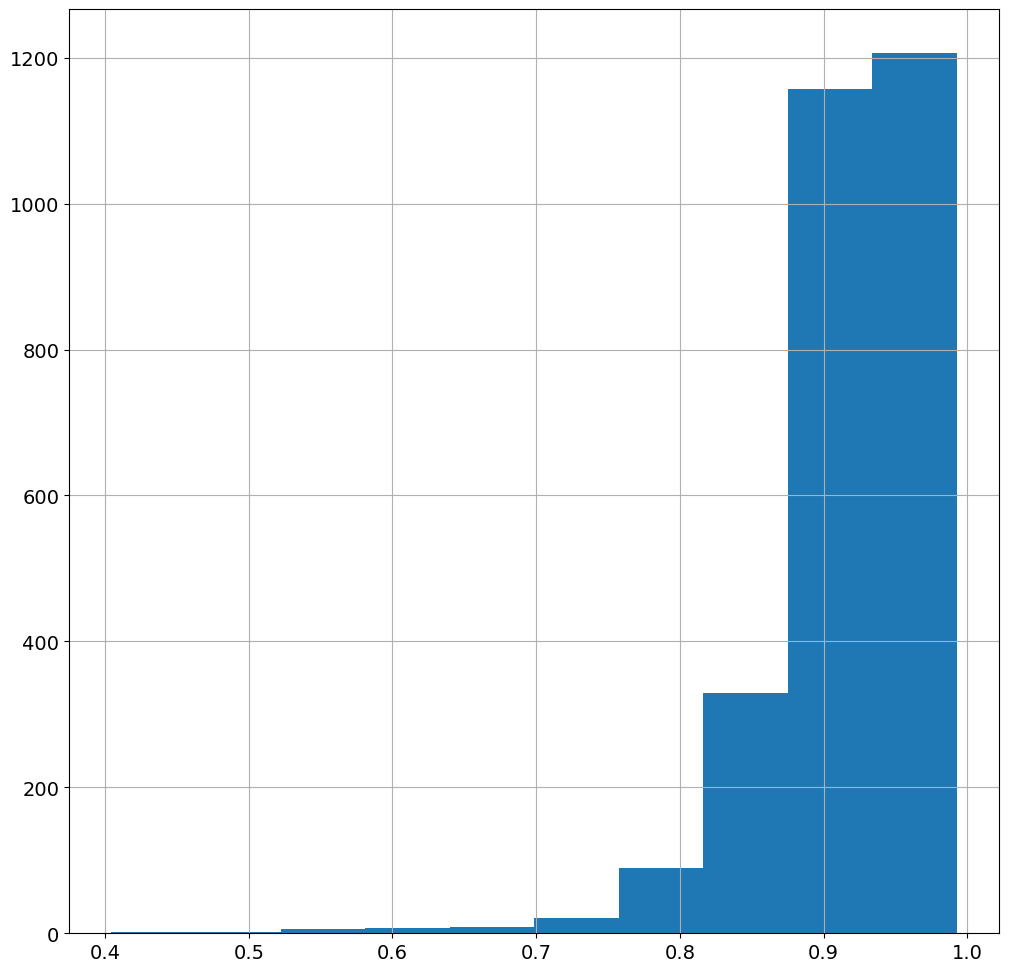

In [35]:
pd.Series(model.predict_proba(X_test)[:, 1]).hist(figsize=(12,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Descion Tree distribution 

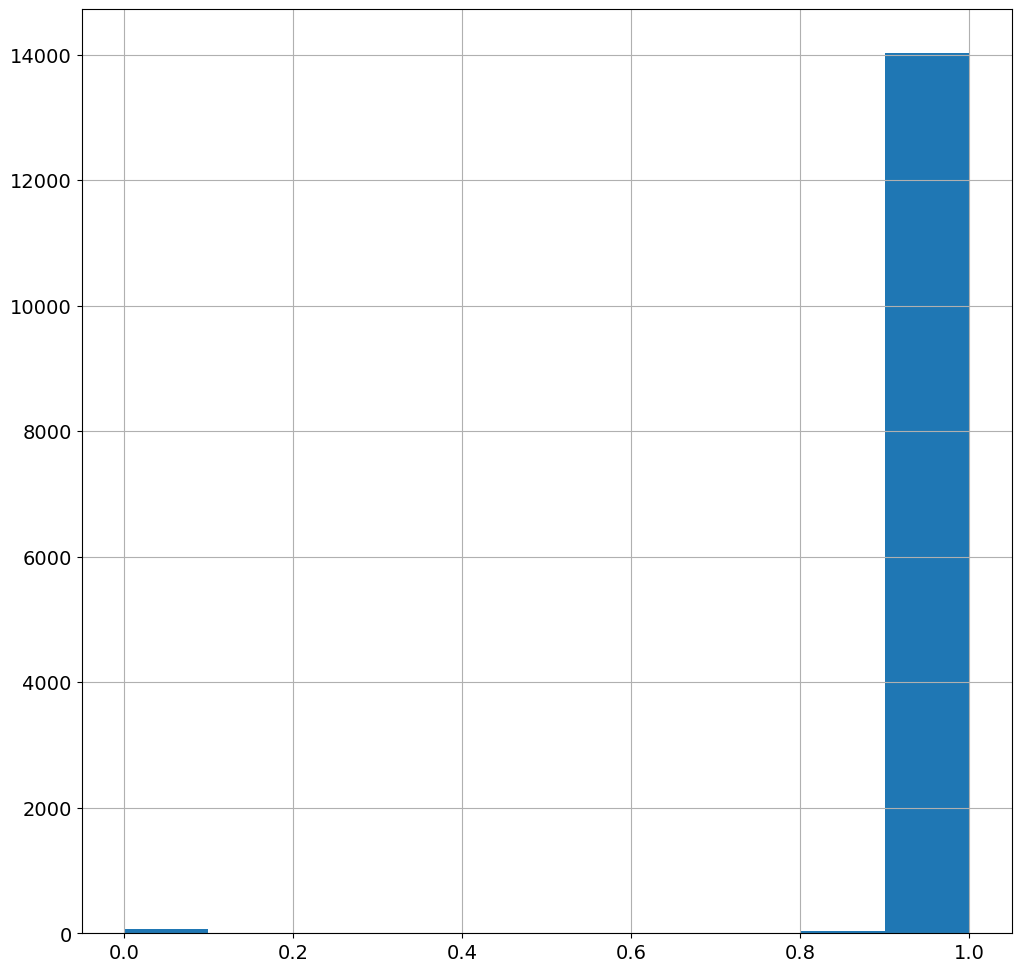

In [36]:
pd.Series(clf.predict_proba(x)[:, 1]).hist(figsize=(12,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Random Forest distribution 

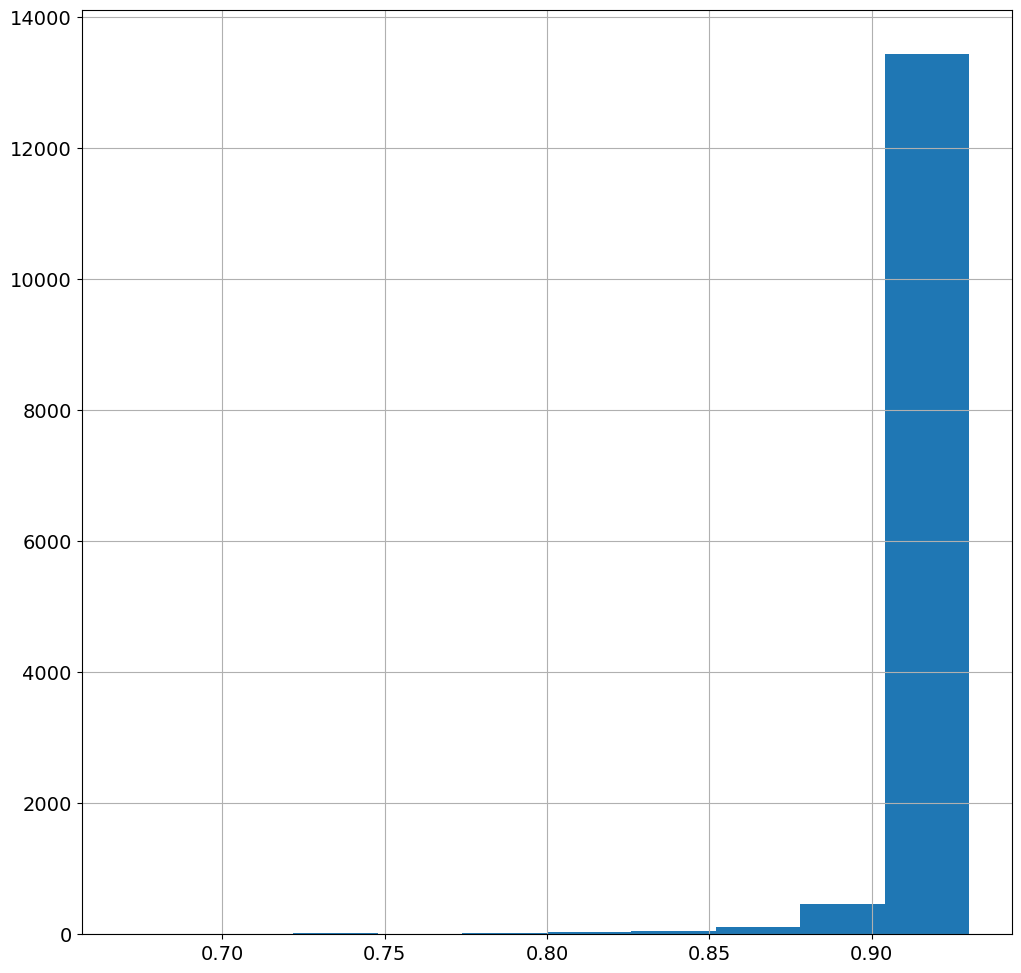

In [37]:
pd.Series(rf.predict_proba(x)[:, 1]).hist(figsize=(12,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

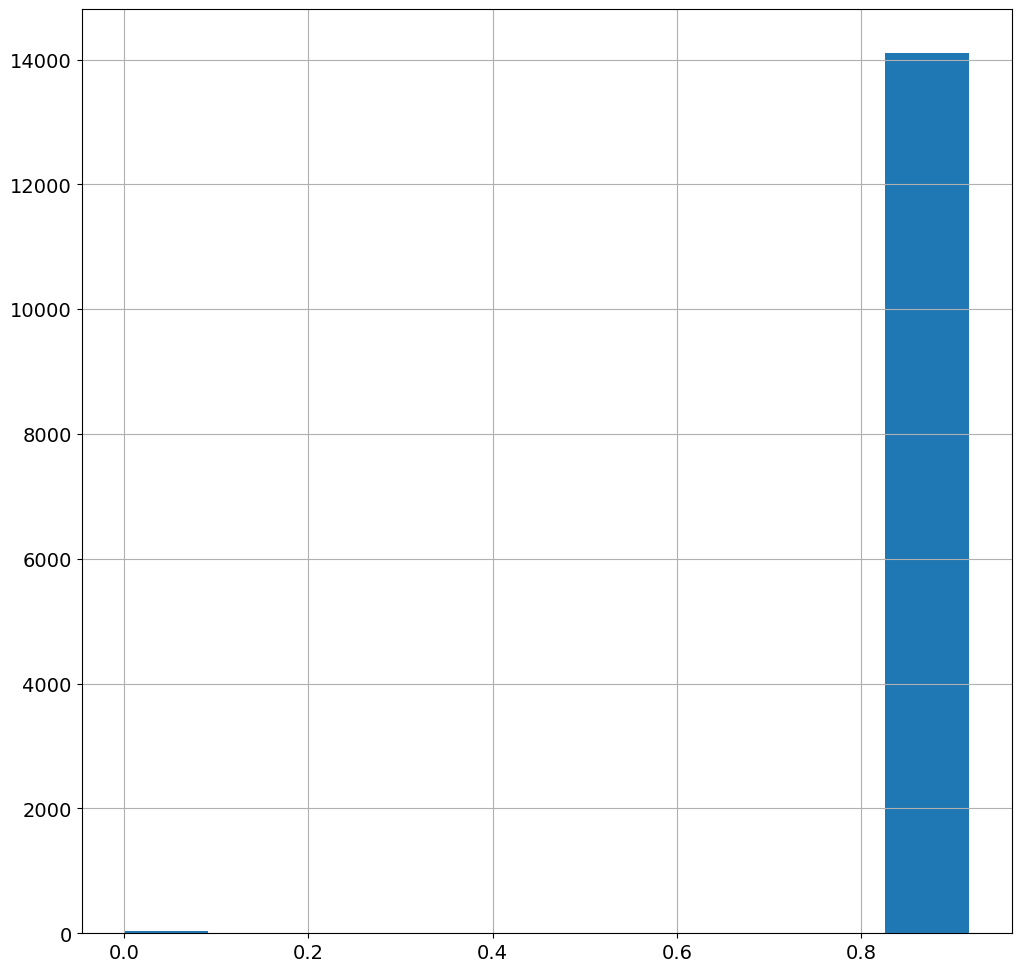

In [38]:
pd.Series(gbc.predict_proba(x)[:, 1]).hist(figsize=(12,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [42]:
for cols in pred_train.columns:
        if pred_train[cols] != pred_train['actual']:
            print(classification_report(pred_train.actual, pred_train[cols]))
for cols in pred_val.columns:
    if pred_val[cols] != pred_val['actual']:
        print(classification_report(pred_val.actual, pred_val[cols]))
for cols in pred_test.columns:
    if pred_test[cols] != pred_test['actual']:
        print(classification_report(pred_test.actual, pred_test[cols]))
            
            


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [46]:
for cols in pred_train.columns:
    if not (pred_train[cols] == pred_train['actual']).all():
        print(f'classification_report for {cols} with training data')
        print('=====================================================')
        print(classification_report(pred_train.actual, pred_train[cols]))

for cols in pred_val.columns:
    if not (pred_val[cols] == pred_val['actual']).all():
        print(f'classification_report for {cols} with validate data')
        print('=====================================================')
        print(classification_report(pred_val.actual, pred_val[cols]))

for cols in pred_test.columns:
    if not (pred_test[cols] == pred_test['actual']).all():
        print(f'classification_report for {cols} with test data')
        print('=====================================================')
        print(classification_report(pred_test.actual, pred_test[cols]))

classification_report for logistic with training data
              precision    recall  f1-score   support

           0       0.73      0.01      0.02       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.82      0.51      0.49      7914
weighted avg       0.90      0.92      0.88      7914

classification_report for descion_tree with training data
              precision    recall  f1-score   support

           0       0.95      0.06      0.11       664
           1       0.92      1.00      0.96      7250

    accuracy                           0.92      7914
   macro avg       0.94      0.53      0.53      7914
weighted avg       0.92      0.92      0.89      7914

classification_report for random_forest with training data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       664
           1       0.92      1.00      0.96      7250

    accurac

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/l